Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/Resized MRI 224/Training/pituitary', '/content/drive/MyDrive/Resized MRI 224/Training/glioma', '/content/drive/MyDrive/Resized MRI 224/Training/notumor', '/content/drive/MyDrive/Resized MRI 224/Training/meningioma']
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Train : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Valid : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test  : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Physical devices cannot be modified after being initialized
Epoch 1/50
357/357 [==============================] - 1215s 3s/step - loss: 2.3654 - accuracy: 0.5590 - val_loss: 0.6181 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 2/50
357/357 [==============================] - 241s 675ms/step - loss: 2.

<function matplotlib.pyplot.legend(*args, **kwargs)>

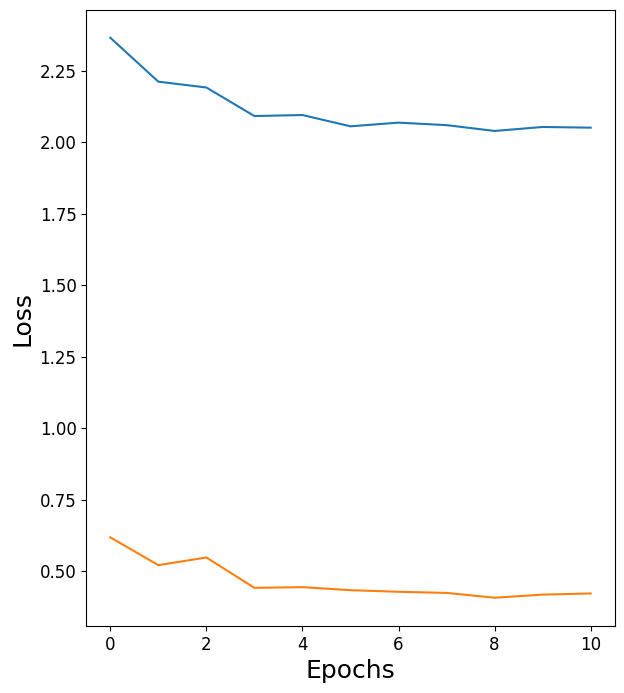

In [6]:
import tensorflow as tf
import numpy as np
from sklearn.utils import check_random_state
from skimage.transform import resize
from skimage.segmentation import slic
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping
from collections import Counter
from glob import glob
import matplotlib.pyplot as plt

# Function to apply PatchUp augmentation
def apply_patchup(images, patch_size):
    patched_images_list = []

    for image in images:
        patch_x = tf.random.uniform((), 0, image.shape[0] - patch_size, dtype=tf.int32)
        patch_y = tf.random.uniform((), 0, image.shape[1] - patch_size, dtype=tf.int32)

        patched_image_a = image
        patched_image_b = image

        patch_a = image[patch_x:patch_x + patch_size, patch_y:patch_y + patch_size]
        patch_b = images[np.random.randint(len(images))][patch_x:patch_x + patch_size, patch_y:patch_y + patch_size]

        indices_a = tf.stack(tf.meshgrid(tf.range(patch_x, patch_x + patch_size), tf.range(patch_y, patch_y + patch_size), indexing='ij'), axis=-1)
        indices_b = tf.stack(tf.meshgrid(tf.range(patch_x, patch_x + patch_size), tf.range(patch_y, patch_y + patch_size), indexing='ij'), axis=-1)

        patched_image_a = tf.tensor_scatter_nd_update(image, indices_a, patch_b)
        patched_image_b = tf.tensor_scatter_nd_update(image, indices_b, patch_a)

        patched_images_list.append(patched_image_a)
        patched_images_list.append(patched_image_b)

    return tf.stack(patched_images_list)


# Apply augmentation to training data generator
def custom_image_data_generator(generator, patch_size):
    while True:
        batch_x, batch_y = next(generator)
        batch_x_augmented = []
        batch_y_augmented = []

        for i in range(batch_x.shape[0]):
            image_a = batch_x[i]
            rand_idx = np.random.randint(0, batch_x.shape[0])
            image_b = batch_x[rand_idx]
            patched_images = apply_patchup([image_a, image_b], patch_size)

            batch_x_augmented.extend(patched_images)
            batch_y_augmented.extend([batch_y[i]] * len(patched_images))

        yield np.array(batch_x_augmented), np.array(batch_y_augmented)

# Modify the training data generator
patch_size = 32  # Define the patch size for PatchUp augmentation

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Managing GPU & RAM
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Import libraries
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from collections import Counter
from glob import glob

# Resize Images & Copy Dataset Path
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
train_path = '/content/drive/MyDrive/Resized MRI 224/Training'
validate_path = '/content/drive/MyDrive/Resized MRI 224/Testing'
test_path = '/content/drive/MyDrive/Resized MRI 224/Testing'

# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Resized MRI 224/Training/*')
print(folders)

# Image Data Generator
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
validate_datagen = ImageDataGenerator()

# Training Dataset - Augmentation Rules
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True)

# Create augmented training data generator
augmented_training_set = custom_image_data_generator(training_set, patch_size)

# Validating Dataset - Augmentation Rules
validate_set = test_datagen.flow_from_directory(validate_path,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True)

# Testing Dataset - Augmentation Rules
testing_set = test_datagen.flow_from_directory(test_path,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=False)

# Labels
labels = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validate_set.class_indices)
print('Test  :', testing_set.class_indices)

# Compute Weights
def compute_weights(dataset):
    counter = Counter(dataset.classes)
    class_weights = {class_id: (1 / num_images) * float(sum(counter.values())) / 2 for class_id, num_images in counter.items()}
    return class_weights

# EfficientNetB0 Model
inputs = layers.Input(shape=(img_height,img_width,3))
base_model = EfficientNetV2B0(include_top=False,
                              weights="imagenet",
                              input_tensor=inputs,
                              input_shape=(img_height,img_width,3),
                              pooling='avg')

base_output = base_model.output
x = layers.Dense(units=1280, activation='relu', name='dense_1')(base_output)
x = layers.Dense(units=640, activation='relu', name='dense_2')(x)
outputs = layers.Dense(units=len(folders), activation='softmax', name='final_softmax')(x)
model_efficientnet = tf.keras.Model(inputs, outputs)

# Fine Tuning - ImageNet Weights Are Kept The Same
base_model.trainable = True

# Model Compiling = Loss, Optimizer & Metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_efficientnet.compile(loss='categorical_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])

# Fitting The Model
TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1, patience=1, verbose=1, mode='min', min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=2, mode='min', restore_best_weights=True)
callbacks_list = [TON, control_lr, early_stopping]
class_weights = compute_weights(training_set)

import tensorflow as tf

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

training_history = model_efficientnet.fit(
    augmented_training_set,
    validation_data=validate_set,
    epochs=50,
    steps_per_epoch=len(training_set),
    validation_steps=len(validate_set),
    class_weight=class_weights,
    callbacks=callbacks_list)

# Save the model
model_efficientnet.save("/content/drive/MyDrive/models/EfficientNetV2B0-PatchUp2")

# Visualize training history
fig = plt.figure(figsize=(15, 8))

fig.add_subplot(1, 2, 1)
plt.plot(training_history.history["loss"], label='Training Set')
plt.plot(training_history.history["val_loss"], label='Validation Set')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the libraries as shown below

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.convnext import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping


from tensorflow.keras.models import Sequential
from collections import Counter
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob

import tensorflow as tf
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import ast #to easily read out class text file that contains some unknwn syntax.
import scipy   #to upscale the image
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [4]:
# Resize Images & Copy Dataset Path
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
train_path = '/content/drive/MyDrive/Resized MRI 224/Training'
validate_path = '/content/drive/MyDrive/Resized MRI 224/Testing'
test_path = '/content/drive/MyDrive/Resized MRI 224/Testing'

# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Resized MRI 224/Testing/*')
print(folders)

# Image Data Generator
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
validate_datagen = ImageDataGenerator()

# Training Dataset - Augmentation Rules
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)



# Validating Dataset - Augmentation Rules
validate_set = test_datagen.flow_from_directory(validate_path,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=True)

# Testing Dataset - Augmentation Rules
testing_set = test_datagen.flow_from_directory(test_path,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

# Labels
labels = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validate_set.class_indices)
print('Test  :', testing_set.class_indices)

['/content/drive/MyDrive/Resized MRI 224/Testing/pituitary', '/content/drive/MyDrive/Resized MRI 224/Testing/glioma', '/content/drive/MyDrive/Resized MRI 224/Testing/notumor', '/content/drive/MyDrive/Resized MRI 224/Testing/meningioma']
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Train : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Valid : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test  : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [5]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/models/EfficientNetV2B0-PatchUp2')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

In [6]:
model.evaluate(testing_set)

41/41 [==============================] - 731s 18s/step - loss: 0.4070 - accuracy: 0.9870


[0.4070145785808563, 0.9870327711105347]

41/41 [==============================] - 79s 2s/step


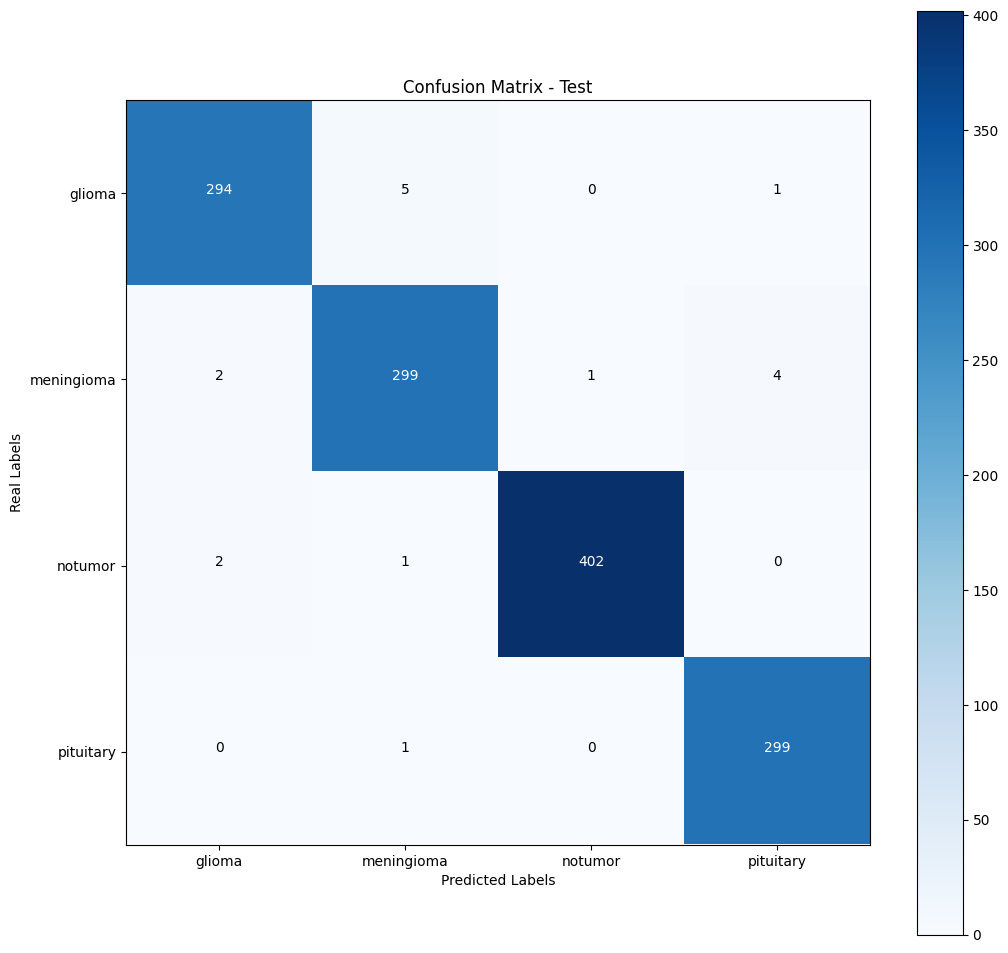

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediction : use the test set (testing_set)
import tensorflow as tf
import itertools
import numpy as np

predictions = model.predict(testing_set)
y_pred = np.argmax(predictions, axis = 1)
#y_test = np.argmax(testing_set.classes, axis = 1)

labels = testing_set.class_indices
#labels = ['BNE', 'BA', 'EO','ERB','LY','MMY','MO','MY','PLT','PMY','SNE']
title = "Test"

# Calculate and display the confucsion matrix
cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
# cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')

# cnf_matrix = confusion_matrix(tf.argmax(testing_set.classes, axis = 1), y_pred, normalize = 'true')

classes = range(len(labels))


plt.figure(figsize = (12,12))
plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion Matrix - "+title)
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i, j in itertools.product(range(cnf_matrix.shape[0]),
                                range(cnf_matrix.shape[1])):
  plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Real Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [8]:
from sklearn.metrics import classification_report
print(classification_report(testing_set.classes, y_pred,target_names = labels))

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.98      0.98      0.98       306
     notumor       1.00      0.99      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

